# Education EDA

This notebook explores educational assessment data provided by the [Department of Education's National Center for Education Statistics (NCES) in the Ed*Facts*]('https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html') dataset collection.

# Notebook Outline

1. [Get the Data](#Get-the-Data)

2. [Preview Data and Structure](#Preview-Data)

3.  [MATH ASSESSMENT](#Math-Assessment-Data)

4. [Reading & Language Arts (RLA) Assessment](#Reading-and-Language-Arts-Assessment)

[Census Broadband Dataa](#Census-Broadband-Data)

[Census Device Data](#Census-Device-Data)

[Geographical Data](#Geographical-Data)

In [4]:
## Import necessary modules:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
## for visualizations:
import seaborn as sns
## for viewing missing values
import missingno as msno
## for editing Regular Expressions:
import re

# Get the Data:

## Data Overview

The website contains:

### Data Files:
- School Year (AY 2013 - 2018)
- Subject (Math or Reading/Language Arts)
- Metric (achievement, participation, or adjusted cohort graduation rate)
- Geographical Unit (Local Education Agency (LEA) or school)

### Documentation:
- Documentation
- Data Notes (state notes)
- Performance Mapping

For this project, we're focusing on:
- Academic Year **2017-18** published April 2020
- **Math** AND **Reading / Language Arts** Scores
- **Achievement** metric for success
- **Local Education Agency** to link with census data

### Direct Links:

The datasets used in this project are linked here directly.

[Math Achievement Percentage Proficiency by Local Education Agency, 2017-18](https://www2.ed.gov/about/inits/ed/edfacts/data-files/math-achievement-lea-sy2017-18.csv)

[Reading / Language Arts Achievement Percentage Proficiency by Local Education Agency, 2017-18](https://www2.ed.gov/about/inits/ed/edfacts/data-files/rla-achievement-lea-sy2017-18.csv)

### Additional Data:

The workflow below can be used to quickly select additional datasets by year, subject, metric, or geography:

In [6]:
<!--

## Prompt for input on customizable datasets
subject=input("Enter Assessment Subject: 'math' for math OR 'rla' for reading / language arts")
geog=input("Enter Detail Level: 'lea' for Local Education Agency OR 'sch' for school")
data_file=input("Enter dataset type: 'achievement' for assessment proficiency OR 'participation' for assessment participation OR 'acgr' for Adjusted Cohort Graduation Rate")
school_year=input("Enter academic year as: YYYY-YY")

## Insert input specifications into URL to get from website
df = pd.read_csv('https://www2.ed.gov/about/inits/ed/edfacts/data-files/{subject}-{data_file}-{geog}-sy{school_year}.csv'
                 .format(subject=subject, data_file=data_file,  geog=geog, school_year=school_year),
                 low_memory=False)

## Convert the LEAID column to strings in order to manipulate for merging
df['LEAID'] = df['LEAID'].astype(str)

## Based on reading documentation, remove leading information from LEAID
## Ensure that LEAID has 7 digits to facilitate merging later
df['LEAID'] = df['LEAID'].str.lstrip('9700000US').str.zfill(7)

## Save the file to the data folder with the appropriate name
df.to_pickle('../data/education/{subject}_{data_file}_{school_year}.pkl'.format(subject=subject, data_file=data_file, school_year=school_year))

##Preview Data
df.head()

-->

SyntaxError: invalid syntax (<ipython-input-6-dd7d3329df60>, line 1)

Since we know what data we want, we're going to pass those parameters directly into the data query / call. From here, we'll bring in math data as well as reading / languagee arts data, and then merge the datasets to have one complete dataset of academic achievement: 
- **Percent Proficient in Math and Reading / Language Arts in each Local Education Agency (LEA) for Academic Year 2017-18** 

## Import Math Data

In [7]:
## Define specific variables
subject='math'
data_file='achievement'
geog='lea'
school_year='2017-18'

## Insert input specifications into URL to get from website
math_2018 = pd.read_csv('https://www2.ed.gov/about/inits/ed/edfacts/data-files/{subject}-{data_file}-{geog}-sy{school_year}.csv'
                 .format(subject=subject, data_file=data_file,  geog=geog, school_year=school_year),
                 low_memory=False)

## Convert the LEAID column to strings in order to manipulate for merging
math_2018['LEAID'] = math_2018['LEAID'].astype(str)

## Based on reading documentation, remove leading information from LEAID
## Ensure that LEAID has 7 digits to facilitate merging later
math_2018['LEAID'] = math_2018['LEAID'].str.lstrip('9700000US').str.zfill(7)

## Save the file to the data folder with the appropriate name
math_2018.to_pickle('../data/education/{subject}_{data_file}_{school_year}.pkl'.format(subject=subject, data_file=data_file, school_year=school_year))

## Preview first five observations of dataset
print(math_2018.info())
print(math_2018.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15984 entries, 0 to 15983
Columns: 262 entries, STNAM to MIL_MTHHSPCTPROF_1718
dtypes: int64(2), object(260)
memory usage: 32.0+ MB
None
     STNAM  FIPST    LEAID ST_LEAID             LEANM DATE_CUR  \
0  ALABAMA      1  0100005   AL-101  Albertville City  27MAR19   
1  ALABAMA      1  0100006   AL-048   Marshall County  27MAR19   
2  ALABAMA      1  0100007   AL-158       Hoover City  27MAR19   
3  ALABAMA      1  0100008   AL-169      Madison City  27MAR19   
4  ALABAMA      1  0100011   AL-167        Leeds City  27MAR19   

   ALL_MTH00NUMVALID_1718 ALL_MTH00PCTPROF_1718 MAM_MTH00NUMVALID_1718  \
0                    2892                    45                      5   
1                    2987                    43                     12   
2                    7551                    70                      5   
3                    5668                    76                     47   
4                    1017                    4

From here, the important things we see are:
- Rows: there are just under 16,000 observations in this dataset, each corresponding to a specific LEAID
- Columns: the columns have specific formatting, and perhaps some redundancies

Before touching anything, let's make sure we grabe the Reading and Language Arts dataset so that we can look at them both as a whole. Follow the same steps as prior, ensuring that we get the same general shape (same number of observations, at least - the exact number of features is not important at the moment).

## Import Reading / Language Arts Data

In [8]:
subject='rla'
data_file='achievement'
geog='lea'
school_year='2017-18'

## Insert input specifications into URL to get from website
rla_2018 = pd.read_csv('https://www2.ed.gov/about/inits/ed/edfacts/data-files/{subject}-{data_file}-{geog}-sy{school_year}.csv'
                 .format(subject=subject, data_file=data_file,  geog=geog, school_year=school_year),
                 low_memory=False)

## Convert the LEAID column to strings in order to manipulate for merging
rla_2018['LEAID'] = rla_2018['LEAID'].astype(str)

## Based on reading documentation, remove leading information from LEAID
## Ensure that LEAID has 7 digits to facilitate merging later
rla_2018['LEAID'] = rla_2018['LEAID'].str.lstrip('9700000US').str.zfill(7)

## Save the file to the data folder with the appropriate name
rla_2018.to_pickle('../data/education/{subject}_{data_file}_{school_year}.pkl'
                   .format(subject=subject, data_file=data_file, school_year=school_year))

## Preview first five observations of dataset
print(rla_2018.head())
print(rla_2018.info())

     STNAM  FIPST    LEAID ST_LEAID             LEANM DATE_CUR  \
0  ALABAMA      1  0100005   AL-101  Albertville City  27MAR19   
1  ALABAMA      1  0100006   AL-048   Marshall County  27MAR19   
2  ALABAMA      1  0100007   AL-158       Hoover City  27MAR19   
3  ALABAMA      1  0100008   AL-169      Madison City  27MAR19   
4  ALABAMA      1  0100011   AL-167        Leeds City  27MAR19   

   ALL_RLA00NUMVALID_1718 ALL_RLA00PCTPROF_1718 MAM_RLA00NUMVALID_1718  \
0                    2885                    38                      5   
1                    2984                    36                     12   
2                    7522                    65                      5   
3                    5654                    74                     46   
4                    1017                    41                      2   

  MAM_RLA00PCTPROF_1718  ... MIL_RLA05NUMVALID_1718 MIL_RLA05PCTPROF_1718  \
0                    PS  ...                     14                  LT50   
1   

Interestingly, the number of columns matches, but the range of observations is slightly bigger (just over 16,000) The explanation for why is in the previously linked documentation. However, since the number is minimal (about 200), we'll go ahead and continue merging the math and reading/language arts datasets, using LEAID as the common identifier.

In [9]:
## Merge observations, using LEAID index as merging reference
## Only keep the data from each set that has an index in the other set (inner)
assessments_2018 = pd.merge(math_2018, rla_2018, how='inner', on='LEAID')

## Save all assessments data
assessments_2018.to_pickle('../data/education/assessments_2018.pkl')

## Preview information about dataframe
assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16020 entries, 0 to 16019
Columns: 523 entries, STNAM_x to MIL_RLAHSPCTPROF_1718
dtypes: int64(4), object(519)
memory usage: 64.0+ MB


In [10]:
## Ensure that data saved correctly by reading
assessments_2018 = pd.read_pickle('../data/education/assessments_2018.pkl')
assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16020 entries, 0 to 16019
Columns: 523 entries, STNAM_x to MIL_RLAHSPCTPROF_1718
dtypes: int64(4), object(519)
memory usage: 64.0+ MB


Now we have one dataset that contains all the information for nationwide assessments saved.

## Preview Assessment Data Shape

In [11]:
## Observe shape of data
assessments_2018.shape

(16020, 523)

Great. So this merge shows us that we have a dataset with 2 datatypes, 523 columns, and around 16,000 entries. In the following steps, we get some more quick observations about the data in order to combine it with Census data shortly.

In [12]:
## Observe types of data
assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16020 entries, 0 to 16019
Columns: 523 entries, STNAM_x to MIL_RLAHSPCTPROF_1718
dtypes: int64(4), object(519)
memory usage: 64.0+ MB


By looking at the shape and information of the data, we can immediately glean some useful informatino that will be applicable to our analysis later:

- **Too many unknown columns** - Observing the info we know that 523 columns is too many to read completely through. 
- **Incorrect datatypes** - We see that only 4 of these columns are listed as integers, even though the documentation listed these valess as percentages, so we'll have to handle those later. 
- **Unique identifiers?** - While we think we have 16,000 observations for school districts, we should confirm that these are in fact unique values that can be used to join census data later. 

Reading the documentation helps us with the first issue of too many columns.

#### Columns


The first set of columns contains identifying data:
- STNAME - State Name
- FIPST - ANSI 2-digit code for state
- LEAID - NCES-assigned District ID
- ST_LEAID - State-assigned District ID
- LEANM - District Name
- DATE_CUR - Date of data snapshot

And the rest contain various groupings of the data for each observation (LEA) in the following format:
- \[SUBGROUP\]_\[SUBJECT\]\[GRADE\]\[METRIC\]_\[SCHOOLYEAR\]

Reading the [documentation]('https://www2.ed.gov/about/inits/ed/edfacts/data-files/assessments-sy2017-18-public-file-documentation.docx') provides an overview of those columns, along with their corresponding meanings:

- **Subgroups** - Major Racial and Ethnic Groups / Special Populations
    - ALL - All Students in the school
    - Racial Subgroups (begin with M):
        - MAM American Indian/Alaska Native
        - MAS Asian/Pacific Islander
        - MHI Hispanic
        - MBL Black
        - MWH White
        - MTR Two or More Races
    - Special Population Subgroups:
        - CWD Children with disabilities
        - ECD Economically disadvantaged
        - LEP Limited English proficiency
        - HOM Homeless
        - MIG Migrant
        - FCS Foster Care Status
        - MIL Military Connected (new for '17-'18)
        
- **Subject** - Specific to each file.
    - Math (MTH) or Reading/Language Arts (RLA)
    
- **Grade** 
    - 00 - aggregated across all grades
    - 03-08 - Grades 3-8
    - HS - High School
    
- **Metric**
    - numvalid - # of students who completed assessment proficient
    - pctprof - % of students proficient or higher
    
- **School Year**
    - Limited to 2017-18 in this case
    - May be able to add additional years later for better understanding
    
So, for example, the column labeled "**MBL_MTH08PCTPROF_1718**" describes: 
- in 2017-18 **\[1718\]**,
- for Black students **\[MBL\]** 
- studying Math **\[MTH\]**
- in the Eighth grade **\[08\]**, 
- what Percentage were deemed Proficient **\[PCTPROF\]**



Knowing and observing this breakdown and groupings could prove helpful in improving the model later. For now, however, we'll keep only the following columns:
- 'LEAID' - as our identifier / index. We'll convert this to a 7-digit string for concatenation.
- 'ALL_MTH00PCTPROF_1718' and 'ALL_RLA00PCTPROF_1718' - This provides predictor columns to which we can append other datasets to get predictions

Given the business understanding established previously, it makes sense to limit ourselves to these two predictor columns. So for the scope of this project, we'll limit the dataset to these three columns:

In [13]:
## Create new dataframe which only contains desired features
all_assessments_2018 = assessments_2018[['LEAID','ALL_MTH00PCTPROF_1718','ALL_RLA00PCTPROF_1718']]
print(all_assessments_2018.info())
print(all_assessments_2018.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16020 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   LEAID                  16020 non-null  object
 1   ALL_MTH00PCTPROF_1718  16020 non-null  object
 2   ALL_RLA00PCTPROF_1718  16020 non-null  object
dtypes: object(3)
memory usage: 500.6+ KB
None
     LEAID ALL_MTH00PCTPROF_1718 ALL_RLA00PCTPROF_1718
0  0100005                    45                    38
1  0100006                    43                    36
2  0100007                    70                    65
3  0100008                    76                    74
4  0100011                    40                    41


#### Rows
There are almost 16,000 rows here. They appear to be unique observations for each Local Education Agency (LEA), but let's confirm:

In [14]:
## Ensure that LEAID is a unique value for each observation
all_assessments_2018['LEAID'].nunique() == all_assessments_2018.shape[0]
## Returns True if all values are unique, False if there are duplicates

False

Alas, it appears that there are duplicate values. Let's see how many before we proceed, as this could impact our merge with census data, since we're using the LEAID as our merging identifier.

In [15]:
## Show how frequently each LEAID appears
all_assessments_2018['LEAID'].value_counts(sort=True).head(10)

0000000    49
0000030     4
0200030     4
0000010     4
0000060     4
3904421     1
2012900     1
2311220     1
4014100     1
1811430     1
Name: LEAID, dtype: int64

From the documentation, LEAID = State FIPS \[2 digits\] + Unified School District (UNSD) Code \[5 digits\]. Since no state is assigned to "00", these are probably pseudo-districts or placeholders of some sort. Relative to the roughly 16,000 other school districts, this is a small number. So we'll only select the observations which have a unique LEAID before merging and preparing the data for the Machine Learning task.

In [364]:
## Drop observations with duplicate LEAIDs
new_assessments_2018 = all_assessments_2018.drop_duplicates(subset='LEAID')

## Create a copy so that "copy of slice of dataframe" error does not appear
new_assessments_2018 = pd.DataFrame(new_assessments_2018).copy()

In [365]:
## Confirm unique identifiers again
## Prints True if all items are unique, prints False if not
new_assessments_2018['LEAID'].nunique() == new_assessments_2018.shape[0]

True

In [366]:
## Preview new dataset
new_assessments_2018.head()

,LEAID,ALL_MTH00PCTPROF_1718,ALL_RLA00PCTPROF_1718
0,0100005,45,38
1,0100006,43,36
2,0100007,70,65
3,0100008,76,74
4,0100011,40,41


In [367]:
#Ensure that most of the data remains unharmed
new_assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15960 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   LEAID                  15960 non-null  object
 1   ALL_MTH00PCTPROF_1718  15960 non-null  object
 2   ALL_RLA00PCTPROF_1718  15960 non-null  object
dtypes: object(3)
memory usage: 498.8+ KB


Great. Since the unique number of LEAIDs (15960) matches the total number of observations for the dataset, we know that it is a unique value. We can use this value as our index later. The only issue remaining, which we will return to later, is the datatypes for all the columns - they are objects and not integers or floats, as we would want them to be if they were percentages being put into a regression.

# Explore Data

In this section we'll explore and visualize the assessment data a little bit more, and prepare it for merging with geographic data and eventually census data as well: handling missing values, converting datatypes, and visualizing the data.

First, for better readability, we'll change the names of the columns:

In [368]:
new_assessments_2018.rename(columns={'ALL_MTH00PCTPROF_1718': 'math_prof', 'ALL_RLA00PCTPROF_1718': 'rla_prof'}, inplace=True)
new_assessments_2018.head()

,LEAID,math_prof,rla_prof
0,0100005,45,38
1,0100006,43,36
2,0100007,70,65
3,0100008,76,74
4,0100011,40,41


## Missing Values

In [369]:
## Look at the shape of the dataset again
new_assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15960 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LEAID      15960 non-null  object
 1   math_prof  15960 non-null  object
 2   rla_prof   15960 non-null  object
dtypes: object(3)
memory usage: 498.8+ KB


This shows that the dataset has 15960 entries, with 15960 of them non-null - i.e., zero null values!

Can this be true? We'll take a further look. The missingno package helps to visualize if there are any missing values in the dataframe:

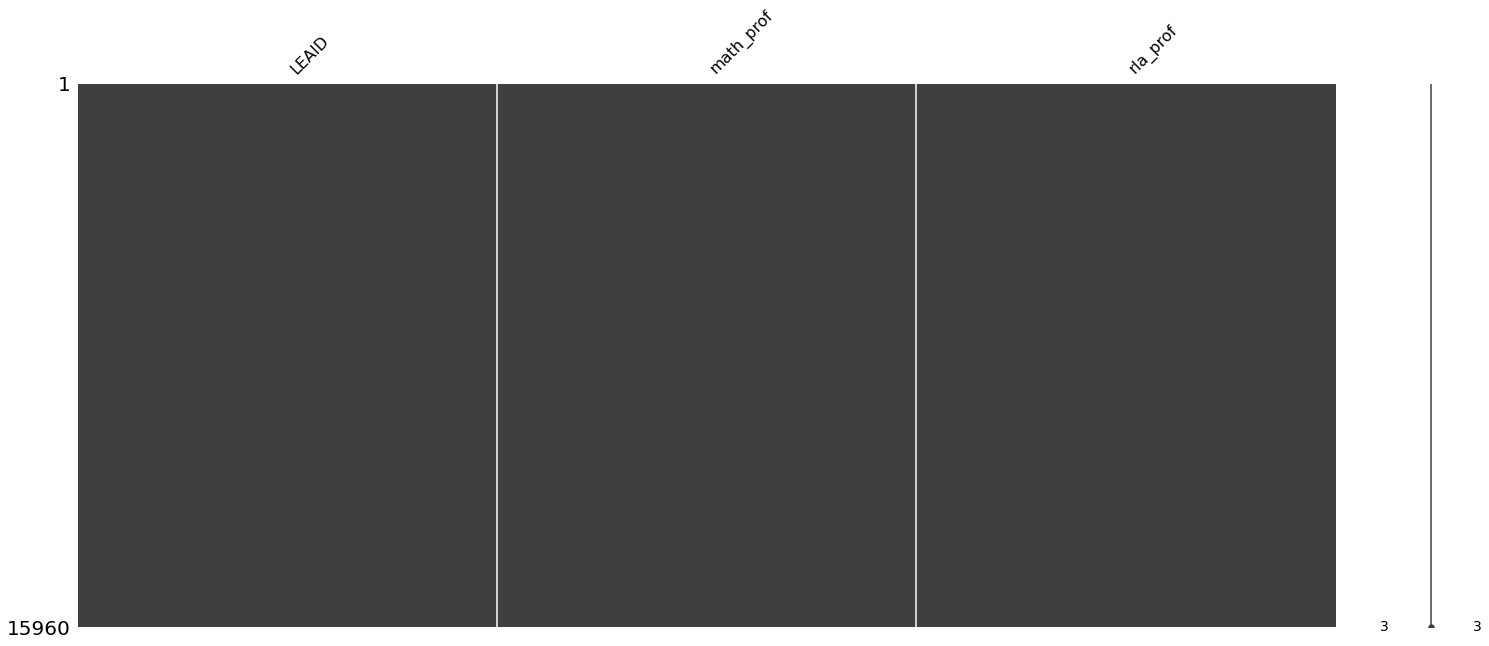

In [370]:
## Display missing values in missing no package
msno.matrix(new_assessments_2018);

Looking more granularly at the data:

In [371]:
## View first 20 values in each column
new_assessments_2018.head(20)

,LEAID,math_prof,rla_prof
0,0100005,45,38
1,0100006,43,36
2,0100007,70,65
3,0100008,76,74
4,0100011,40,41
5,0100012,41,40
6,0100013,76,71
7,0100030,42,40
8,0100060,39,41
9,0100090,21,25


Already we see one major issue, it looks like some of the data is saved as ranges, and not integers or floats. Let's look at the tail:

In [372]:
## View last 20 values in each column
new_assessments_2018.tail(20)

,LEAID,math_prof,rla_prof
16000,5604260,40,53
16001,5604380,70-74,55-59
16002,5604450,9,12
16003,5604500,53,55
16004,5604510,46,51
16005,5604830,51,60
16006,5604860,65,63
16007,5605090,51,54
16008,5605160,60,61
16009,5605220,41,41


In [373]:
## Check values in individual columns
new_assessments_2018.math_prof.value_counts()

30-34    320
35-39    304
40-44    294
25-29    293
45-49    280
        ... 
95         4
96         2
94         2
GE99       2
97         1
Name: math_prof, Length: 137, dtype: int64

In [374]:
# check values in individual columns
new_assessments_2018.rla_prof.value_counts()

40-44    355
35-39    320
45-49    316
30-34    285
50-54    283
        ... 
96         5
95         5
6          4
94         4
3          3
Name: rla_prof, Length: 136, dtype: int64

So before we can begin analyzing and visualizing the data, we'll have to handle the numerical data that's represented by strings in the proficiency columns.

## Convert Datatypes

Further inspection reveals that "nan" values, "." values (also described as blank in documentation),  ranges, and strings are complicating the numerical analysis. Referring again to the documentation, these variations were intentionally introduced for student privacy concerns, with the following codes:

- GE - Greater than or equal to
- LE - Less than or equal to
- GT Greater than
- LT - Less than
- PS - Privacy Suppressed (<5 students)

Specifically, as specified in Part 1.5 and Table 2 of the documentation for 2017-18, for schools with less than 300 students, "As the number of students reported increases, the magnitude of the range decreases". 

Given these ranges, we could make a few choices:

1. Dropna
    - Drop all values that are not integers
    - This would leave too few observations
    
2. Bin score ranges, for example:
    - Smaller scale (e.g., 25-29)
    - Medium-scale (e.g., Very High proficiency (>80%), high proficiency (60-80), proficient (40-60), low proficiency (20-40), very low proficiency (0-20)
    - Large scale (e.g., >= 50% as proficient)

3. Create integer out of ranges:
    - Replace the string ranges (e.g., 50-55) with averages 
    - We can then convert these strings to numerical datatypes
    

For this analysis, we'll go with:
- option 1 (drop) for observations that have letters in them
    - Those ranges would be too wide to provide informative datapoints 
    - (e.g., % proficient > 50 could be anywhere between 50-100, and is not very accurate
    
- option 3 (create integer) for observations that have ranges
    - We'll do this by averaging the two scores within the range
    - This will allow us to perform a regression instead of a classification
    - A regression will allow us to perform more detailed analysis later on
    - This will also allow for better customization later on after the model is created.

### Convert ranges to integer averages

In [375]:
assessments_test = new_assessments_2018.copy()

In [376]:
## Create function to turn ranges into integer averages

def range_cleaner(number):
    """Create average from range of numbers with "-" in them.
    
    Parameters: 
    number(string, int, float): Any number that might be a range (have "-")
    
    Returns:
    int:Returning value
    
    """
    
    number = str(number) # Convert values to string to enable RegEx functionality
    if '-' in number: # Check if there is a dash in the string
        x, y = number.split('-') # Divide the string into two numbers, splitting on dash
        number = (int(x) + int(y)) / 2 # set number equal to the average  of x and y
        number = int(number) # convert these new values to integers
        return number #returns modified number
    else:
        return number #returns untouched numbers
    

In [377]:
## Test the function
number = '31-42'
number = range_cleaner(number)
print(number)
print(type(number))

36
<class 'int'>


In [378]:
## Apply range cleaner function to test dataset math proficiency column
assessments_test.math_prof = assessments_test.math_prof.apply(range_cleaner)

## Apply range cleaner function to test dataset reading/language arts proficiency column
assessments_test.rla_prof = assessments_test.rla_prof.apply(range_cleaner)

In [379]:
assessments_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15960 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LEAID      15960 non-null  object
 1   math_prof  15960 non-null  object
 2   rla_prof   15960 non-null  object
dtypes: object(3)
memory usage: 498.8+ KB


### Remove letter range observations

In [380]:
## Create function to change values with letters to NaN
def remove_letters(number):
    """Remove range abbreviations GE, GT, LT, LE, PS from series
    
    Parameters: 
    number(string, int, float): A number that may have any of the above abbreviations in it
    
    Returns:
    int:Returning value
    
    """
    number = str(number) # Convert values to string to enable RegEx functionality
    remove_values = ['GT', 'GE', 'LT', 'LE', 'PS',] # Specify values to remove, as defined above
    for value in remove_values: # Loop through each of the 5 values
        if re.search(value, number): # Check if the value is in the string
            number = 'REMOVE' # Assign a string to know to remove/convert to nan for dropping
        else:
            number = number # If not satisfied, only return untouched number
    number = pd.to_numeric(number, errors='coerce') # set all values to numeric datatypes
    return number

In [381]:
## Test the function

new = '24'
new = remove_letters(new)
print(new)
print(type(new))

24
<class 'numpy.int64'>


In [382]:
## Apply remove letters function to test dataset math proficiency column
assessments_test.math_prof = assessments_test.math_prof.apply(remove_letters)

## Apply remove letters function to test dataset reading/language arts proficiency column
assessments_test.rla_prof = assessments_test.rla_prof.apply(remove_letters)

In [383]:
## Drop nan values (which we intentionally created in the previous steps)
assessments_test.dropna(inplace=True)

In [384]:
## Preview the new shape of the dataset
## Ensure not too many values dropped
## Double check datatypes, etc.
assessments_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14864 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LEAID      14864 non-null  object 
 1   math_prof  14864 non-null  float64
 2   rla_prof   14864 non-null  float64
dtypes: float64(2), object(1)
memory usage: 464.5+ KB


Looking at the shape of the dataset above, it looks like we're still good. We went from about 16,000 observations to just under 15,000. So we deleted about 1,000 observations which had wide ranges as values.

Additionally, we can see that since we removed letter values, the math and reading / language arts proficiency percentages are all numerical datatyes. 

Since this works, we'll apply both functions to the dataset:

### Apply both functions to both columns

In [385]:
## Apply range cleaner function to test dataset math proficiency column
new_assessments_2018.math_prof = new_assessments_2018.math_prof.apply(range_cleaner)

## Apply range cleaner function to test dataset reading/language arts proficiency column
new_assessments_2018.rla_prof = new_assessments_2018.rla_prof.apply(range_cleaner)

new_assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15960 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LEAID      15960 non-null  object
 1   math_prof  15960 non-null  object
 2   rla_prof   15960 non-null  object
dtypes: object(3)
memory usage: 498.8+ KB


In [386]:
## Apply remove letters  function to dataset math proficiency column
new_assessments_2018.math_prof = new_assessments_2018.math_prof.apply(remove_letters)

## Apply remove letters function to dataset reading/language arts proficiency column
new_assessments_2018.rla_prof = new_assessments_2018.rla_prof.apply(remove_letters)
new_assessments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15960 entries, 0 to 16019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LEAID      15960 non-null  object 
 1   math_prof  14920 non-null  float64
 2   rla_prof   15099 non-null  float64
dtypes: float64(2), object(1)
memory usage: 498.8+ KB


In [388]:
## Remove the values we intentionally set to nan
new_assessments_2018.dropna(inplace=True)
new_assessments_2018.shape

(14864, 3)

In [389]:
new_assessments_2018.head()

,LEAID,math_prof,rla_prof
0,0100005,45.0,38.0
1,0100006,43.0,36.0
2,0100007,70.0,65.0
3,0100008,76.0,74.0
4,0100011,40.0,41.0


In [390]:
new_assessments_2018.describe()

,math_prof,rla_prof
count,14864.000000,14864.000000
mean,43.466362,48.853471
std,18.372749,17.386347
min,2.000000,2.000000
25%,30.000000,37.000000
50%,42.000000,48.000000
75%,56.000000,62.000000
max,98.000000,98.000000


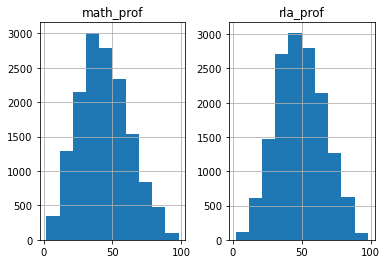

In [391]:
new_assessments_2018.hist();

In [394]:
new_assessments_2018.to_pickle('../data/education/new_assessments_2018.pkl')

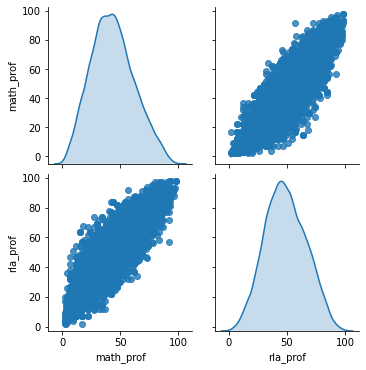

In [395]:
sns.pairplot(new_assessments_2018, vars=['math_prof', 'rla_prof'], kind='reg', diag_kind='kde');

As is probably expected, there is a definite correlation between Reading/Language Arts Scores and Math Scores for the limited dataset we're observing. It should be noted that the math score distribution skews slightly to the left. The RLA score skews to the right. This phenomenon is confirmed in the statistical summary which shows us that the mean math score is 45% and the mean reading/language arts score is 55%.

## Append geographic data to entire set

In [ ]:
geo_assessments_2018 = pd.merge(new_assessments_2018, [shapefiles??])

### Visualize

In [ ]:
combined_assessments_2018 = pd.merge(whole_rla_2018, whole_math_2018, how='inner', on='LEAID').dropna()
combined_assessments_2018['year'] = 2018
combined_assessments_2018.info

In [ ]:
combined_assessments_2018.to_pickle('../data/education/combined_assessments_2018.pkl')